In [221]:
using CSV, DataFrames
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw

In [222]:
region = "Japan"
magnitude_threshold = 3.0 

3.0

In [223]:
# Select 3 of the best cell sizes from parameter dependency analysis
if magnitude_threshold == 0.0 
    if region == "Romania"
        cell_sizes = [3.5,  4.5,  5.5];
        multiplier = [0.6, 1.0, 1.5]
    elseif region == "Italy"
        cell_sizes = [4.0, 4.5, 5.0];
        multiplier = [0.4, 1.0, 2.5]
    elseif region == "California"
        cell_sizes = [1.0, 1.5, 2.0];
        multiplier = [0.8, 1.0, 2.2]
    elseif region == "Japan"
        cell_sizes = [2.5, 3.0, 3.5];
        multiplier = [0.3, 1.0, 3.0]
    end;
elseif magnitude_threshold == 1.0 
    if region == "Romania"
        cell_sizes = [3.5,  4.0,  4.5];
        multiplier = [0.6, 1.0, 1.5]
    elseif region == "Italy"
        cell_sizes = [4.0, 4.5, 5.5];
        multiplier = [0.4, 1.0, 2.5]
    elseif region == "California"
        cell_sizes = [4.0, 5.0, 6.0];
        multiplier = [0.1, 1.0, 5.0]
    elseif region == "Japan"
        cell_sizes = [4.0, 4.5, 6.0];
        multiplier = [0.3, 1.0, 3.0]
    end;
elseif magnitude_threshold == 2.0 
    if region == "Romania"
        cell_sizes = [13.5, 14.5, 15.0];
        multiplier = [0.1, 1.0, 10.0]
    elseif region == "Italy"
        cell_sizes = [6.5, 7.0, 8.0];
        multiplier = [0.4, 1.0, 4.5]
    elseif region == "California"
        cell_sizes = [4.0, 5.0, 5.5];
        multiplier = [0.1, 1.0, 5.0]
    elseif region == "Japan"
        cell_sizes = [2.0, 2.5, 5.5];
        multiplier = [0.1, 1.0, 2.0]
    end;
elseif magnitude_threshold == 3.0 
    if region == "Romania"
        cell_sizes = [16.5,  18.5,  19.0];
        multiplier = [0.1, 1.0, 10.0]
    elseif region == "Italy"
        cell_sizes = [12.5, 14.5, 19.0];
        multiplier = [0.4, 1.0, 5.0]
    elseif region == "California"
        cell_sizes = [12.5, 13.0, 14.5];
        multiplier = [0.01, 0.1, 1.0]
    elseif region == "Japan"
        cell_sizes = [4.0, 5.0, 5.5];
        multiplier = [0.3, 1.0, 3.0]
    end;
end

# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
df = df[df.Magnitude .> magnitude_threshold,:];

# Make path for results
mkpath("./results/$region")

    

"./results/Japan"

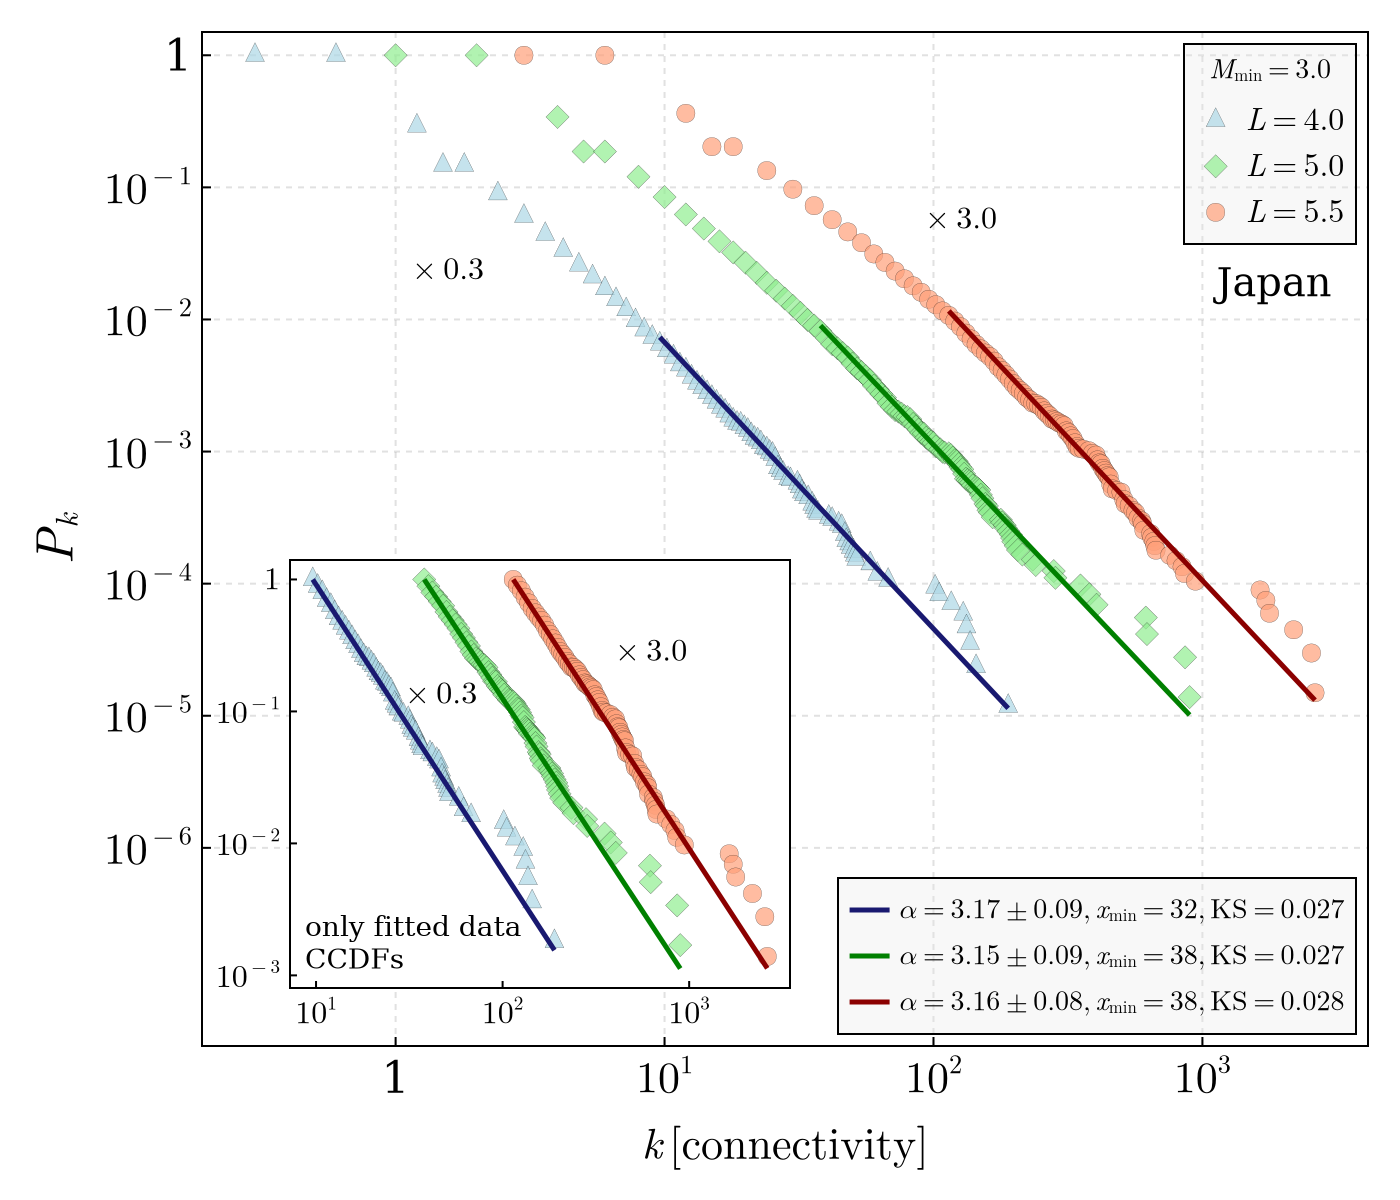

In [224]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(size = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)

########################################## TRUNCATED
ax2 = Axis(fig, bbox = BBox(145,395,106,320), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

sc1 = Array{Any,1}(undef,3)

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=2)
    sigma = round(fit.sigma, digits=2)
    xmin = Int(round(fit.xmin, digits=2))
    KS = round(fit.power_law.KS(data=degrees), digits=3)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

    sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha) \pm %$(sigma),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
    color=line_colors[i], linewidth=2.5, strokewidth=5) 


    ########################################### TRUNCATED
    # CCDF of truncated data (fitted), the plot, (re-normed)
    scatter!(ax2, multiplier[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data (re-normed)
    lines!(ax2, multiplier[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

end


text!(ax2, "only fitted data\nCCDFs", space = :relative, position = Point2f(0.03, 0.03))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


# Top right, cell size legend
axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_{\min}=%$(magnitude_threshold)", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=16);
# Bottom left, results legend
axislegend(ax1, position = :rb, backgroundcolor = (:grey90, 0.25), labelsize=14);



## Values for plot spreading and manual title positioning

if region == "Romania"
    if magnitude_threshold == 0.0
        text!(ax1, "Romania", space = :relative, position = Point2f(0.84, 0.73), fontsize=20)
        ylims!(ax1, 10^(-5.5), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3)],["1", L"10^{1}", L"10^{2}", L"10^{3}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(2), 10^(3)], [L"10^{2}", L"10^{3}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.7), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.13, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)

    elseif magnitude_threshold == 1.0
        text!(ax1, "Romania", space = :relative, position = Point2f(0.84, 0.73), fontsize=20)
        ylims!(ax1, 10^(-5.5), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3)],["1", L"10^{1}", L"10^{2}", L"10^{3}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(2), 10^(3)], [L"10^{2}", L"10^{3}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.7), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.13, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)

    elseif magnitude_threshold == 2.0
        text!(ax1, "Romania", space = :relative, position = Point2f(0.837, 0.73), fontsize=20)
        ylims!(ax1, 10^(-5.5), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.9), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.13, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.75, 0.75), fontsize=16)
    
    elseif magnitude_threshold == 3.0
        text!(ax1, "Romania", space = :relative, position = Point2f(0.837, 0.73), fontsize=20)
        ylims!(ax1, 10^(-5.5), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.9), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.8, 0.85), fontsize=16)
    
    end
    
elseif region == "Italy"
    if magnitude_threshold == 0.0
        text!(ax1, "Italy", space = :relative, position = Point2f(0.88, 0.73), fontsize=20)
        ylims!(ax1, 10^(-6), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.52, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.12, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)

    elseif magnitude_threshold == 1.0 
        text!(ax1, "Italy", space = :relative, position = Point2f(0.88, 0.73), fontsize=20)
        ylims!(ax1, 10^(-6), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.52, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.12, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)

    elseif magnitude_threshold == 2.0
        text!(ax1, "Italy", space = :relative, position = Point2f(0.88, 0.73), fontsize=20)
        ylims!(ax1, 10^(-6), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.12, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.55, 0.75), fontsize=16)

    elseif magnitude_threshold == 3.0
        text!(ax1, "Italy", space = :relative, position = Point2f(0.88, 0.73), fontsize=20)
        ylims!(ax1, 10^(-6), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.65, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.6), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.55, 0.75), fontsize=16)

    end
elseif region == "California"
    if magnitude_threshold == 0.0 
        text!(ax1, "California", space = :relative, position = Point2f(0.83, 0.73), fontsize=18)
        ylims!(ax1, 10^(-7), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(2), 10^(3),10^(4)], [L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.63, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.15, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)

    elseif magnitude_threshold == 1.0 
        text!(ax1, "California", space = :relative, position = Point2f(0.825, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.43, 0.65), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.7, 0.85), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.6), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.75, 0.75), fontsize=16)

    elseif magnitude_threshold == 2.0 
        text!(ax1, "California", space = :relative, position = Point2f(0.825, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7), 1.5)
        ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.7, 0.8), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.75, 0.75), fontsize=16)

    elseif magnitude_threshold == 3.0 
        text!(ax1, "California", space = :relative, position = Point2f(0.83, 0.73), fontsize=18)
        ylims!(ax1, 10^(-5), 1.5)
        ax1.xticks = ([10^(-2), 10^(-1), 10^(0) ,10^(1),10^(2),10^(3),10^(4)],[L"10^{-2}", L"10^{-1}", "1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(-2), 10^(-1), 10^(0) ,10^(1),10^(2), 10^(3),10^(4)], [L"10^{-2}", L"10^{-1}", "1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.35, 0.63), fontsize=16)
        text!(ax1, L"\times %$(multiplier[2])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.15, 0.5), fontsize=16)
        text!(ax2, L"\times %$(multiplier[2])", space = :relative, position = Point2f(0.71, 0.45), fontsize=16)

    end
elseif region == "Japan"
    if magnitude_threshold == 0.0
        text!(ax1, "Japan", space = :relative, position = Point2f(0.87, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7.5), 1.5)
        ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.5, 0.8), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)

    elseif magnitude_threshold == 1.0
        text!(ax1, "Japan", space = :relative, position = Point2f(0.87, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7.5), 1.5)
        ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.5, 0.8), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)

    elseif magnitude_threshold == 2.0 
        text!(ax1, "Japan", space = :relative, position = Point2f(0.87, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7.5), 1.5)
        ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.62, 0.8), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.23, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.65, 0.75), fontsize=16)

    elseif magnitude_threshold == 3.0
        text!(ax1, "Japan", space = :relative, position = Point2f(0.87, 0.73), fontsize=20)
        ylims!(ax1, 10^(-7.5), 1.5)
        ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
        ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

        ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
        ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

        # multipliers text
        text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
        text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.62, 0.8), fontsize=16)
        
        text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.23, 0.65), fontsize=16)
        text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.65, 0.75), fontsize=16)

    end
end

# Save plot
save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.png", fig, px_per_unit=7)
save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.pdf", fig)
fig


## RO 3.0 mag

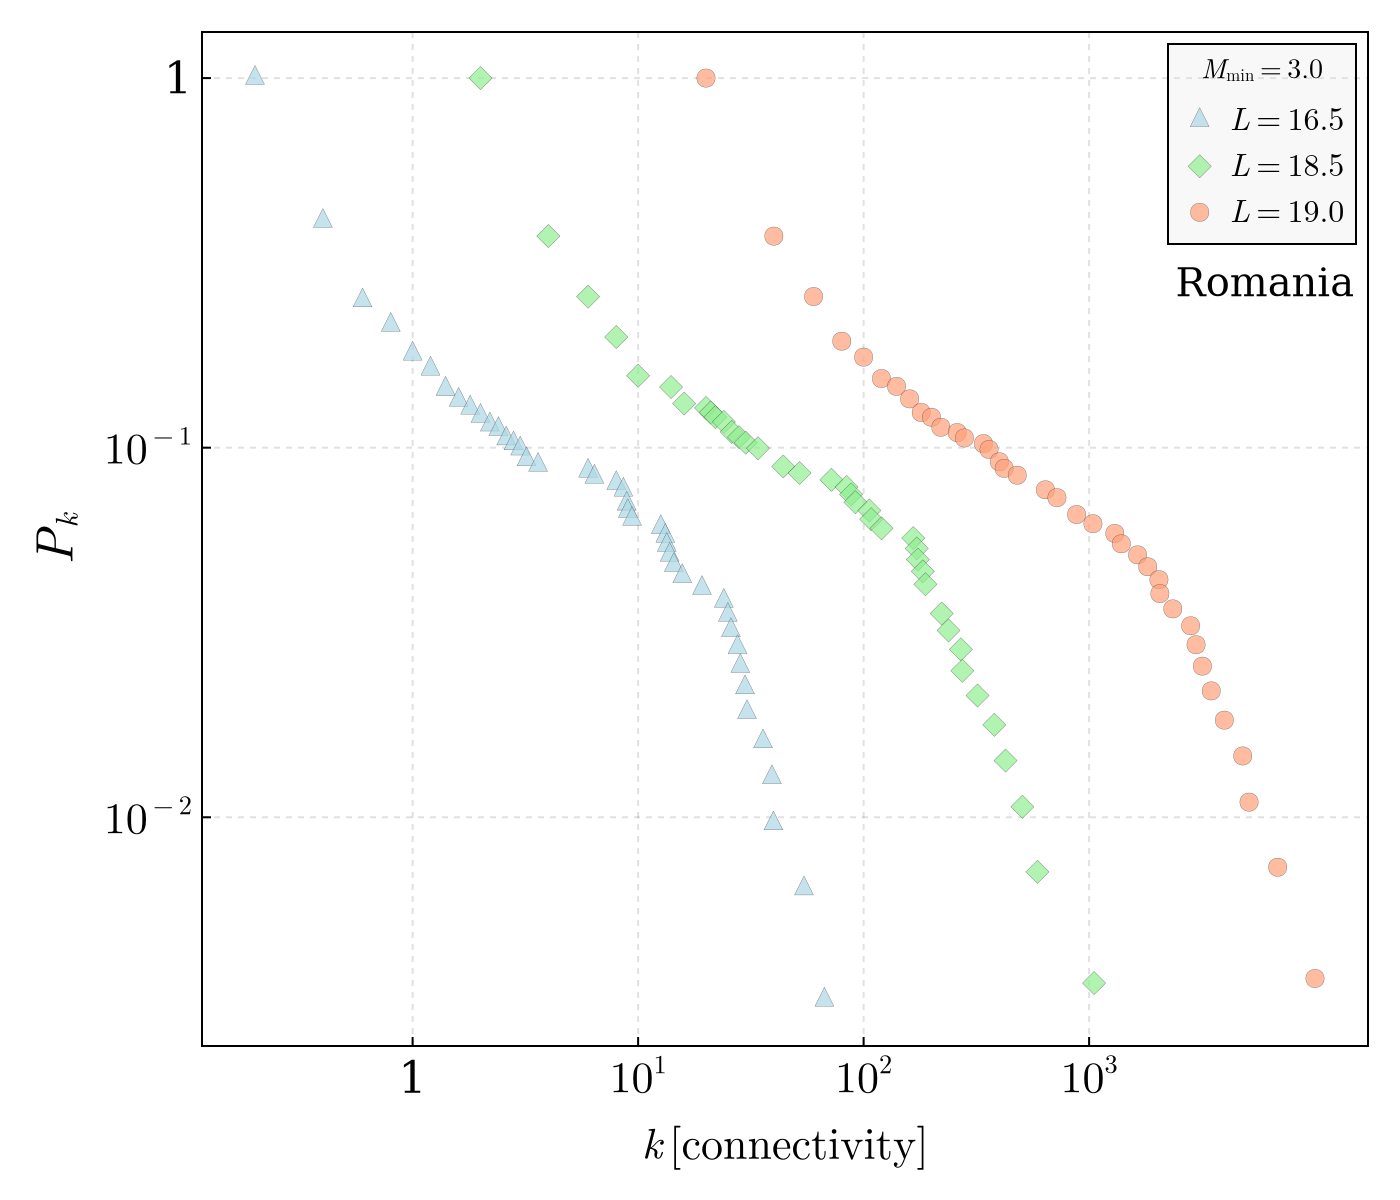

In [220]:
# region = "Romania"
# magnitude_threshold = 3.0 

# cell_sizes = [16.5,  18.5,  19.0];
# multiplier = [0.1, 1.0, 10.0]


# set_theme!(Theme(fonts=(; regular="CMU Serif")))
# fig = Figure(size = (700, 600), font= "CMU Serif") 
# ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
#     xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
#     xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)

# circle]
# colors=[:lightblue, :lightgreen, :lightsalmon]
# line_colors=[:midnightblue, :green, :darkred]

# sc1 = Array{Any,1}(undef,3)

# for i in eachindex(cell_sizes)
#     df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
#     MG = create_network(df, df_cubes)
#     degrees=[]
#     for i in 1:nv(MG)
#         push!(degrees, get_prop(MG, i, :degree))
#     end

#     # Powerlaw Fit
#     fit = powlaw.Fit(degrees);
#     alpha = round(fit.alpha, digits=2)
#     sigma = round(fit.sigma, digits=2)
#     xmin = Int(round(fit.xmin, digits=2))
#     KS = round(fit.power_law.KS(data=degrees), digits=3)

#     # CCDF of truncated data (fitted), x and y values
#     x_ccdf, y_ccdf = fit.ccdf()

#     # The fit (from theoretical power_law)
#     fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
#     x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

#     ########################################### ALL
#     # CCDF of all data scattered 
#     x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

#     sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
#         color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

# end


# # Top right, cell size legend
# axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_{\min}=%$(magnitude_threshold)", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=16);


# text!(ax1, "Romania", space = :relative, position = Point2f(0.835, 0.73), fontsize=20)
# # ylims!(ax1, 10^(-5.5), 1.5)
# ax1.xticks = ([10^(0),10^(1),10^(2),10^(3)],["1", L"10^{1}", L"10^{2}", L"10^{3}"])
# ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])


# # Save plot
# save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.png", fig, px_per_unit=7)
# save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.pdf", fig)
# fig
